<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [2]:
# ANSWER
titanic_csv = pd.read_csv("C:\\temp\\Data Science\\IOD\\data\\titanic_train.csv", index_col='PassengerId')

In [3]:
PR = ProfileReport(titanic_csv)

In [4]:
PR

In [5]:
titanic_csv.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [5]:
# ANSWER
titanic_csv.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
titanic_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [7]:
def bar_chart(data, feature):
    survived = data[data['Survived']==1][feature].value_counts(normalize=True)*100
    dead = data[data['Survived']==0][feature].value_counts(normalize=True)*100
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

In [57]:
def facetgridplot(train, var):
    facet = sns.FacetGrid(train, hue="Survived", aspect=4)
    facet.map(sns.kdeplot, var, shade= True)
    facet.set(xlim=(0, train[var].max()))
    facet.add_legend()
    plt.show();

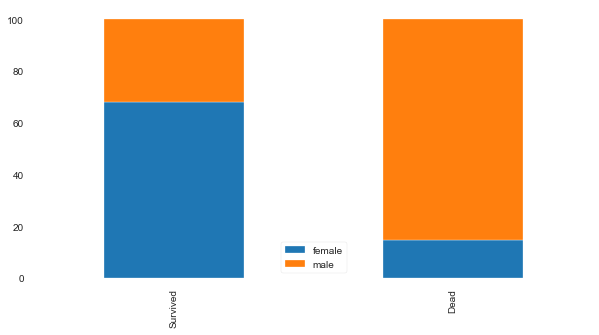

In [8]:
# Survival and Deat reatio as per Sex
bar_chart(titanic_csv, 'Sex')


In [9]:
titanic_csv.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

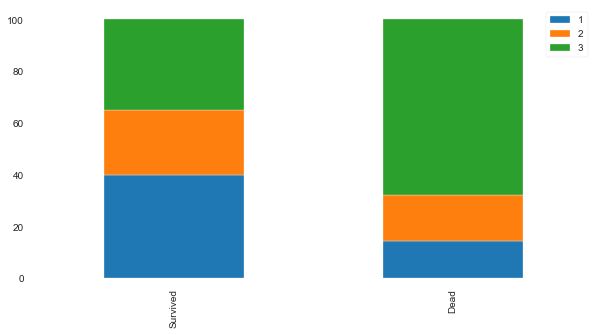

In [10]:
bar_chart(titanic_csv, 'Pclass')

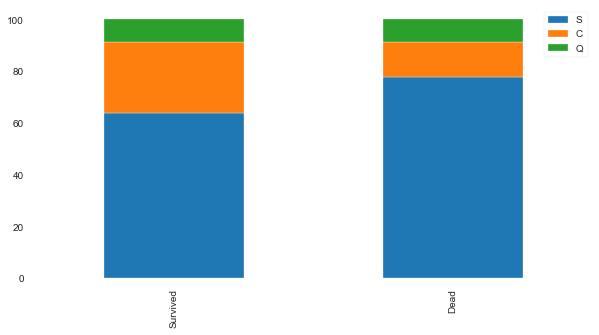

In [11]:
bar_chart(titanic_csv, 'Embarked')

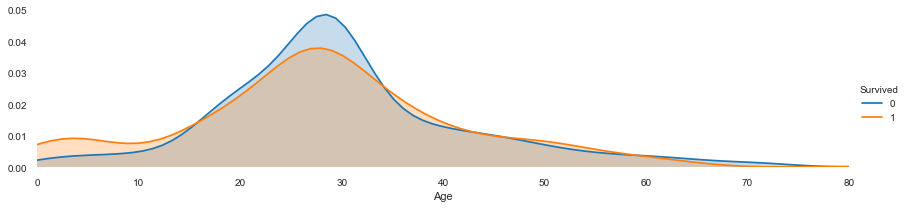

In [58]:
facetgridplot(titanic_csv, 'Age')

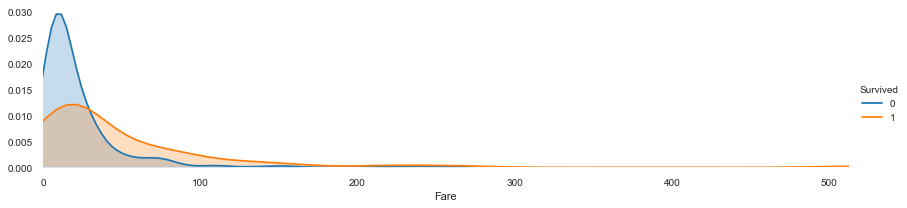

In [59]:
facetgridplot(titanic_csv, 'Fare')

In [12]:
titanic_csv.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [13]:
titanic_csv['Age'].mean()

29.69911764705882

In [14]:
titanic_csv.groupby('Sex')['Age'].mean()

Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64

In [15]:
titanic_csv.groupby('Sex')['Age'].median()

Sex
female    27.0
male      29.0
Name: Age, dtype: float64

In [16]:
titanic_csv['Age'].fillna(titanic_csv.groupby('Sex')['Age'].transform('median'), inplace= True)

In [17]:
titanic_csv.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [18]:
# ANSWER

predictors = ['Pclass', 'Parch']
X = titanic_csv[predictors]
Y = titanic_csv['Survived']

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [19]:
# ANSWER
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

In [20]:
print('Data', titanic_csv.shape)
print('Training:', X_train.shape)
print('Testing:', X_test.shape)

Data (891, 11)
Training: (668, 2)
Testing: (223, 2)


#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [21]:
# ANSWER
# Create Model
logreg = LogisticRegression()

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [22]:
# ANSWER
# Fit Model
logreg.fit(X_train, Y_train)

LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [23]:
# ANSWER
logreg.coef_

array([[-0.87239066,  0.337888  ]])

The computed intercept (`intercept_`) is the 1st element of another array:

In [24]:
# ANSWER
logreg.intercept_

array([1.30430282])

We can create tuples of the predictor names and coefficients like this:

In [25]:
# ANSWER
print(set(zip(predictors, logreg.coef_[0])))

{('Pclass', -0.8723906606017784), ('Parch', 0.33788800487797477)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [26]:
for col in zip(X_train.columns, logreg.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.872391
Parch       +0.337888


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [28]:
# ANSWER
logreg.score(X_train, Y_train)

0.6901197604790419

What is the  `accuracy_score` for the test data?

In [29]:
# ANSWER
logreg.score(X_test, Y_test)

0.6681614349775785

What can we say aout this result?

ANSWER
- ...
- ...

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [30]:
# ANSWER
predictors_1 = ['Pclass', 'Parch', 'Age']
X = titanic_csv[predictors_1]

In [31]:
# Build Model
logreg = LogisticRegression()
#X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y, random_state = 1)

# Fit Model
logreg.fit(X_train, Y_train)
# Score
print('Train Score', logreg.score(X_train, Y_train))
print('Test Score', logreg.score(X_test, Y_test))


Train Score 0.6901197604790419
Test Score 0.6681614349775785


In [32]:
print('Coef', logreg.coef_)
print('Intercept', logreg.intercept_)

Coef [[-0.87239066  0.337888  ]]
Intercept [1.30430282]


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- ...
- ...
- ...

Let's see where the model is going wrong by showing the Confusion Matrix:

In [33]:
# ANSWER
y_pred_class = logreg.predict(X_test)
print(metrics.confusion_matrix(Y_test, y_pred_class))

[[105  23]
 [ 51  44]]


Nb. Here is how `confusion_matrix` arranges its output:

In [34]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: ...

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

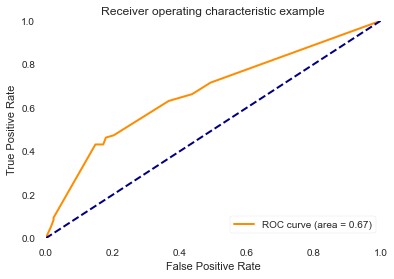

In [35]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [36]:
titanic_with_dummies = pd.get_dummies(data = titanic_csv, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

Survived                                               Name  \
PassengerId                                                                
1                   0                            Braund, Mr. Owen Harris   
2                   1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
3                   1                             Heikkinen, Miss. Laina   
4                   1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
5                   0                           Allen, Mr. William Henry   

              Age  SibSp  Parch            Ticket     Fare Cabin  Sex_female  \
PassengerId                                                                    
1            22.0      1      0         A/5 21171   7.2500   NaN           0   
2            38.0      1      0          PC 17599  71.2833   C85           1   
3            26.0      0      0  STON/O2. 3101282   7.9250   NaN           1   
4            35.0      1      0            113803  53.1000  C123           1   
5            35.0      0      0            373450   8.0500   NaN           0   

             Sex_male  Embarked_C  Embarked_Q  Embarked_S  Pclass_1  Pclass_2  \
PassengerId                                                                     
1                   1           0           0           1         0         0   
2                   0           1           0           0         1         0   
3                   0           0           0           1         0         0   
4                   0           0           0           1         1         0   
5                   1           0           0           1         0         0   

             Pclass_3  
PassengerId            
1                   1  
2                   0  
3                   1  
4                   0  
5                   1

In [37]:
titanic_with_dummies.head()

Survived                                               Name  \
PassengerId                                                                
1                   0                            Braund, Mr. Owen Harris   
2                   1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
3                   1                             Heikkinen, Miss. Laina   
4                   1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
5                   0                           Allen, Mr. William Henry   

              Age  SibSp  Parch            Ticket     Fare Cabin  Sex_female  \
PassengerId                                                                    
1            22.0      1      0         A/5 21171   7.2500   NaN           0   
2            38.0      1      0          PC 17599  71.2833   C85           1   
3            26.0      0      0  STON/O2. 3101282   7.9250   NaN           1   
4            35.0      1      0            113803  53.1000  C123           1   
5            35.0      0      0            373450   8.0500   NaN           0   

             Sex_male  Embarked_C  Embarked_Q  Embarked_S  Pclass_1  Pclass_2  \
PassengerId                                                                     
1                   1           0           0           1         0         0   
2                   0           1           0           0         1         0   
3                   0           0           0           1         0         0   
4                   0           0           0           1         1         0   
5                   1           0           0           1         0         0   

             Pclass_3  
PassengerId            
1                   1  
2                   0  
3                   1  
4                   0  
5                   1

So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [38]:
    titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

In [39]:
titanic_with_dummies.head()

Survived                                               Name  \
PassengerId                                                                
1                   0                            Braund, Mr. Owen Harris   
2                   1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
3                   1                             Heikkinen, Miss. Laina   
4                   1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
5                   0                           Allen, Mr. William Henry   

              Age  SibSp  Parch            Ticket     Fare Cabin  Sex_female  \
PassengerId                                                                    
1            22.0      1      0         A/5 21171   7.2500   NaN           0   
2            38.0      1      0          PC 17599  71.2833   C85           1   
3            26.0      0      0  STON/O2. 3101282   7.9250   NaN           1   
4            35.0      1      0            113803  53.1000  C123           1   
5            35.0      0      0            373450   8.0500   NaN           0   

             Sex_male  Embarked_C  Embarked_Q  Embarked_S  Pclass_1  Pclass_2  \
PassengerId                                                                     
1                   1           0           0           1         0         0   
2                   0           1           0           0         1         0   
3                   0           0           0           1         0         0   
4                   0           0           0           1         1         0   
5                   1           0           0           1         0         0   

             Pclass_3  
PassengerId            
1                   1  
2                   0  
3                   1  
4                   0  
5                   1

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [40]:
# ANSWER
# Set Feature Both Numerical, Categorical
def logreg_score (data, fcols, tcol):
    X = data[fcols]
    Y = data[tcol]
    
    model = LogisticRegression()
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)
    
    model.fit(X_train, Y_train)
    
    return model.score(X_train, Y_train)

In [41]:
features = ['Parch', 'Age', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'SibSp']
target = 'Survived'

logreg_score(titanic_with_dummies, features, target)


0.7035928143712575

Plot the ROC curve for the new model:

In [42]:
# ANSWER

# Define function to plot ROC - Receiver Operating Characteristic
def plot_roc(X_test, Y_test):

    # predict probability of predicted values
    preds = logreg.predict_proba(X_test)[:,1]

    # Calculate false psotivie rate and true positive rate
    fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

    # Calculate area under curve
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC 
    plt.plot(fpr, tpr, color = 'orange', label = 'ROC Curve (Area = %0.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--')
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


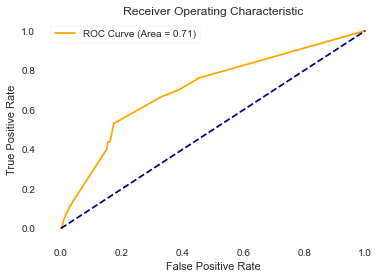

In [43]:
plot_roc(X_train, Y_train)

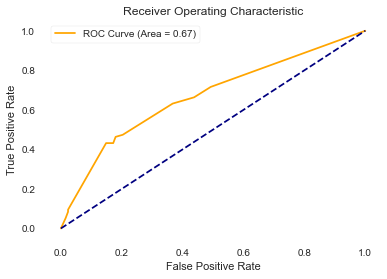

In [44]:
plot_roc(X_test, Y_test)

Can we improve the model by including the remaining features?

In [45]:
titanic_with_dummies.columns

Index(['Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3'],
      dtype='object')

In [46]:
# ANSWER
features = ['Age', 'SibSp', 'Parch', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3']
logreg_score(titanic_with_dummies, features, target)

0.7874251497005988

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

In [47]:
# Cross Validation
from sklearn.model_selection import cross_val_score

features = ['Age', 'SibSp', 'Parch', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3']
target = 'Survived'

logreg = LogisticRegression()

scores = cross_val_score(logreg, titanic_with_dummies[features], titanic_with_dummies[target], cv=5)
print('Scores:', scores)
print('Mean CV Score:', scores.mean())


Scores: [0.79329609 0.78089888 0.78089888 0.75842697 0.80898876]
Mean CV Score: 0.7845019145063084


In [48]:
# TPR and FPR fro best model

x = titanic_with_dummies[features]
y = titanic_with_dummies[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 1)

logreg.fit(x_train, y_train)

y_predict = logreg.predict(x_test)

confusion = metrics.confusion_matrix(y_test, y_predict)

print(confusion)


[[110  18]
 [ 26  69]]


In [49]:
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
TP = confusion[1, 1]

In [50]:
# Accuracy

accuracy = (TP + TN) / (TP + TN + FP + FN)
print('Manual Accuracy:', accuracy)
print('Accuracy by Metrics:', metrics.accuracy_score(y_test, y_predict))

Manual Accuracy: 0.8026905829596412
Accuracy by Metrics: 0.8026905829596412


In [51]:
# Error

error_man = (FP + FN) / (TP + TN + FP + FN)
error_met = 1 - metrics.accuracy_score(Y_test, y_predict)

print('Error my Manual:', error_man)
print('Error by Metrics', error_met)

Error my Manual: 0.19730941704035873
Error by Metrics 0.19730941704035876


In [52]:
# Precision - Precisoin Score - Correct prediction rate
precision_man = TP / (TP + FP)
precision_met = metrics.precision_score(Y_test, y_predict)
print('Precision by Manual:', precision_man)
print('Precision by Metrics', precision_met)

Precision by Manual: 0.7931034482758621
Precision by Metrics 0.7931034482758621


In [54]:
# Recall - True Positive Rate - Sensitivity

recall_man = TP / (TP + FN)
recall_met = metrics.recall_score(Y_test, y_predict)

print('Recall by Man Calc', recall_man)
print('Recall by Metrics', recall_met)


Recall by Man Calc 0.7263157894736842
Recall by Metrics 0.7263157894736842


In [56]:
# False Positive Rate

FPR_man = FP / (FP + TN)
FPR_man

0.140625



---



---



> > > > > > > > > © 2019 Institute of Data


---



---



